# Merging RBD-Ab affinity scores and expression data for downstream `torchdms` analysis (still under construction)

This notebook provides some of the pre-processin and summary statistics for the CCG DMS data which will be used for training a model downstream. 

In [15]:
# Imports
import pickle
import json
import os
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
import glob
import gctree

%matplotlib inline

## 1: Merge and clean raw data

In [16]:
! ls data/tdms_models/tdms-prep/*.prepped.pkl

zsh:1: no matches found: data/tdms_models/tdms-prep/*.prepped.pkl


In [17]:
model_prefix = "model-nonlinear"
outdir = "data/tdms_models/tdms-prep/"
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    print(dsdir[0])

data/tdms_models/tdms-prep/dms-octet-ceiling-4
data/tdms_models/tdms-prep/dms-only
data/tdms_models/tdms-prep/dms-only-drop-na
data/tdms_models/tdms-prep/dms-octet-ceiling


**define the model**

In [18]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    model_config = {
        "default": {
            "data_path": f"{dsdir[0]}/data.prepped.pkl",
            "epochs": 400,
            "independent_starts": 5,
            "include_details": True,
            "loss_fn": "mse",
            "non_lin_bias" : False,
            "output_bias" : False,
            "device" : "cpu",
            "model_string": "FullyConnected;[2,3];[None,'relu']",
            "prefix": f"{dsdir[0]}/{model_prefix}",
            "seed": 10
        }
    }
    with open(f"{dsdir[0]}/{model_prefix}-config.json", "w") as outfile:
        json.dump(model_config, outfile, indent=4)

In [19]:
! tree data/tdms_models/tdms-prep/

data/tdms_models/tdms-prep/
├── dms-octet-ceiling
│   ├── config.json
│   ├── data.prepped.measurements.pdf
│   ├── data.prepped.pkl
│   ├── model-all-gctree-scatter.png
│   ├── model.beta.pdf
│   ├── model-config.json
│   ├── model.error.csv
│   ├── model.error.pdf
│   ├── model.error-summary.csv
│   ├── model.ge.pdf
│   ├── model.heat.pdf
│   ├── model.model
│   ├── model.model_details.pkl
│   ├── model-nonlinear-config.json
│   ├── model-nonlinear-training.log
│   ├── model-octet-scatter.png
│   ├── model.profiles.pdf
│   ├── model.scatter.corr.csv
│   ├── model.scatter.pdf
│   ├── model.sentinel
│   ├── model.svd.pdf
│   ├── model-testset-scatter.png
│   └── training.log
├── dms-octet-ceiling-4
│   ├── config.json
│   ├── data.prepped.measurements.pdf
│   ├── data.prepped.pkl
│   ├── model-all-gctree-scatter.png
│   ├── model.beta.pdf
│   ├── model-config.json
│   ├── model.error.csv
│   ├── model.error.pdf
│   ├── model.error-summary.csv
│   ├── model.ge.pdf
│   ├── model.heat.pdf

In [20]:
! cat data/tdms_models/tdms-prep/dms-octet-ceiling/config.json

{
    "default": {
        "data_path": "data/tdms_models/tdms-prep/dms-octet-ceiling/data.prepped.pkl",
        "epochs": 400,
        "independent_starts": 5,
        "include_details": true,
        "loss_fn": "mse",
        "non_lin_bias": false,
        "output_bias": false,
        "device": "cpu",
        "model_string": "FullyConnected;[2, 3];[None, relu]",
        "prefix": "data/tdms_models/tdms-prep/dms-octet-ceiling/model-nonlinear",
        "seed": 10
    }
}

**fit the models**

Here we will start by fitting three models, all of which are defined the same but with different training data. The architecture is simply the linear model with no bias on the output

In [21]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    ! tdms go --config {dsdir[0]}/{model_prefix}-config.json > {dsdir[0]}/{model_prefix}-training.log
    ! echo "===================================="
    ! echo {dsdir[0]}
    ! tail -n 20 {dsdir[0]}/training.log

data/tdms_models/tdms-prep/dms-octet-ceiling-4
validation loss record: 0.7260611057281494

validation loss record: 0.7220165729522705

validation loss record: 0.7143888473510742
Epoch 00333: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00344: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00355: reducing learning rate of group 0 to 1.0000e-06.
Learning rate dropped below stated minimum. Stopping.
LOG: error plot finished and dumped to data/tdms_models/tdms-prep/dms-octet-ceiling-4/model.error.pdf
LOG: scatter plot finished and dumped to data/tdms_models/tdms-prep/dms-octet-ceiling-4/model.scatter.pdf
LOG: loaded data, evaluating beta coeff for wildtype seq: EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLEYMGYISYSGSTYYNPSLKSRISITRDTSKNQYYLQLNSVTTEDTATYYCARDFDVWGAGTTVTVSSGGGGSGGGGSGGGGSDIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKALIYSASYRYSGVPDRFTGSGSGTDFTLTISNVQSEDLAEYFCQQYNSYPLTFGSGTKLEIKR
LOG: Beta coefficients plotted and dumped to data/tdms_models/tdms-prep/dms-octe

First let's try with octet +  data

In [22]:
! tree data/tdms_models/tdms-prep/

data/tdms_models/tdms-prep/
├── dms-octet-ceiling
│   ├── config.json
│   ├── data.prepped.measurements.pdf
│   ├── data.prepped.pkl
│   ├── model-all-gctree-scatter.png
│   ├── model.beta.pdf
│   ├── model-config.json
│   ├── model.error.csv
│   ├── model.error.pdf
│   ├── model.error-summary.csv
│   ├── model.ge.pdf
│   ├── model.heat.pdf
│   ├── model.model
│   ├── model.model_details.pkl
│   ├── model-nonlinear.beta.pdf
│   ├── model-nonlinear-config.json
│   ├── model-nonlinear.error.csv
│   ├── model-nonlinear.error.pdf
│   ├── model-nonlinear.error-summary.csv
│   ├── model-nonlinear.ge.pdf
│   ├── model-nonlinear.heat.pdf
│   ├── model-nonlinear.model
│   ├── model-nonlinear.model_details.pkl
│   ├── model-nonlinear.profiles.pdf
│   ├── model-nonlinear.scatter.corr.csv
│   ├── model-nonlinear.scatter.pdf
│   ├── model-nonlinear.sentinel
│   ├── model-nonlinear.svd.pdf
│   ├── model-nonlinear-training.log
│   ├── model-octet-scatter.png
│   ├── model.profiles.pdf
│   ├── model.s

**look at test results - did we break the wall?**

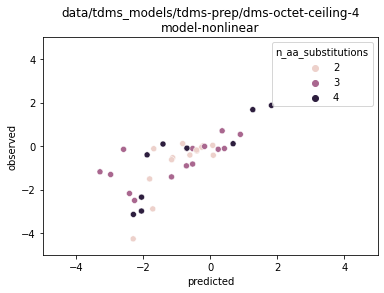

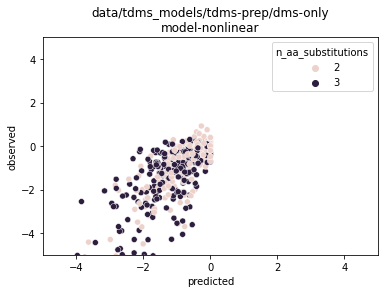

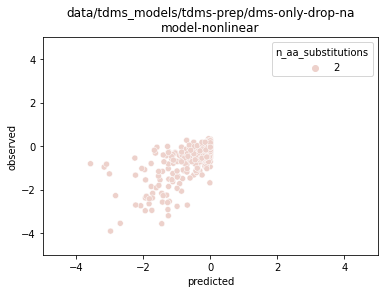

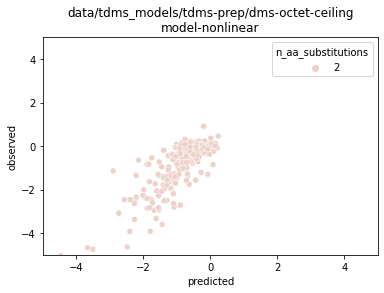

In [61]:
# if this works we can also always just show the correlation plots, at least in the slides?.
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    results = pd.read_csv(f"{dsdir[0]}/{model_prefix}.error.csv")
    fig, ax = plt.subplots()
    g = sns.scatterplot(data=results, y="observed", x="predicted", hue="n_aa_substitutions", ax=ax)
    g.set_ylim((-5, 5))
    g.set_xlim((-5, 5))
    g.set_title(f"{dsdir[0]}\n{model_prefix}")
    plt.show()
    saveto = f"{dsdir[0]}/{model_prefix}-testset-scatter.png"
    fig.savefig(saveto)

# 10: predict on new data

In [43]:
octet_df = pd.read_csv(f"data/tdms_models/raw_dms/octet_data.csv")

In [44]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


In [45]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


data/tdms_models/tdms-prep/dms-octet-ceiling-4
data/tdms_models/tdms-prep/dms-only
data/tdms_models/tdms-prep/dms-only-drop-na
data/tdms_models/tdms-prep/dms-octet-ceiling


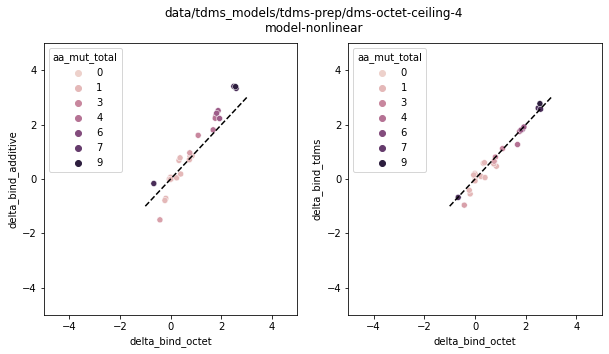

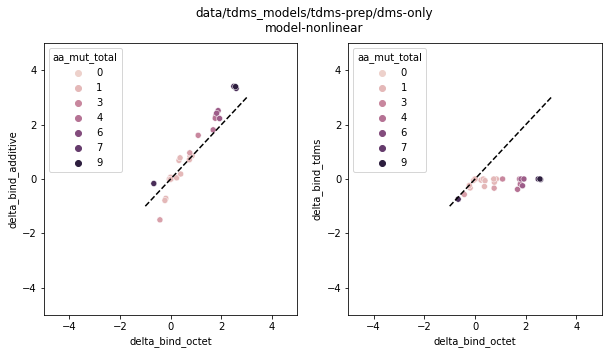

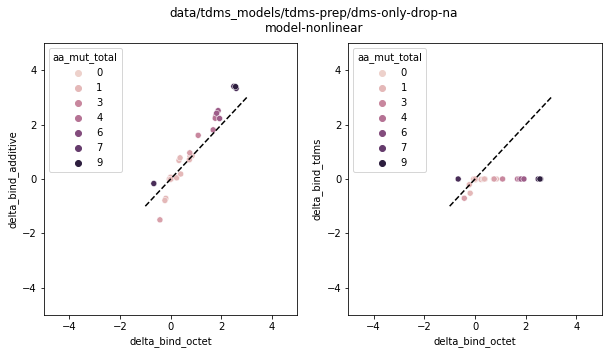

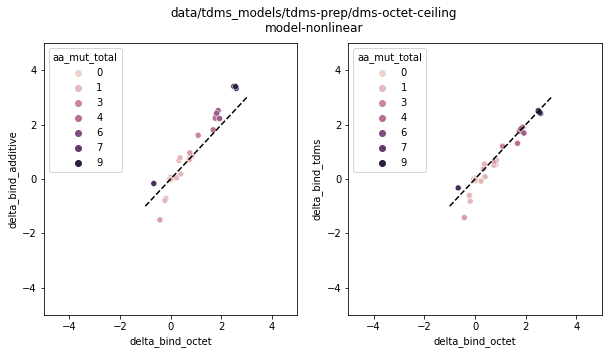

In [46]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    tdms_model = torch.load(f"{dsdir[0]}/{model_prefix}.model", map_location=torch.device('cpu'))
    print(dsdir[0])

    for row_idx, row in octet_df.iterrows():
        igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
        igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
        all_mutations = igh_mutations + igk_mutations
        if any("*" in x for x in all_mutations):
            delta_bind = None
        else:
            delta_bind = dms_df.delta_bind[all_mutations].sum()
        octet_df.loc[row_idx, "delta_bind_additive"] = delta_bind

        aa_seq = pos_df.amino_acid.copy()
    #     print(aa_seq)
        for mutation in all_mutations:
            chain = mutation[-3]
            pos = int(mutation[1:-4])
            wildtype = mutation[0]
            mutant = mutation[-1]
            idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
            assert len(idx) == 1
            idx = idx[0]
            assert aa_seq[idx] == wildtype
            aa_seq[idx] = mutant
    #     print(tdms_model.seq_to_binary("".join(aa_seq)).sum())
        tdms_prediction = tdms_model(tdms_model.seq_to_binary("".join(aa_seq))).detach()# - tdms_prediction_naive
        octet_df.loc[row_idx, "delta_bind_tdms"] = tdms_prediction[0].item()

    octet_df["delta_bind_octet"] = np.log10(octet_df.octet_Kd_foldchange_avg)

    fig, ax = plt.subplots(1, 2, figsize=[10, 5])
    fig.suptitle(f"{dsdir[0]}\n{model_prefix}")
    sns.scatterplot(data=octet_df, y="delta_bind_additive", x="delta_bind_octet", hue="aa_mut_total", ax = ax[0])
    ax[0].plot((-1, 3), (-1, 3), 'k--')
    ax[0].set_ylim((-5, 5))
    ax[0].set_xlim((-5, 5))
    sns.scatterplot(data=octet_df, y="delta_bind_tdms", x="delta_bind_octet", hue="aa_mut_total", ax = ax[1])
    ax[1].plot((-1, 3), (-1, 3), 'k--')
    ax[1].set_ylim((-5, 5))
    ax[1].set_xlim((-5, 5))
    saveto = f"{dsdir[0]}/{model_prefix}-octet-scatter.png"
    plt.savefig(saveto)
#     fig.savefig(f"{model_prefix}-pred-octet.pdf")

## Compare TorchDMS to naive additive model

on tree nodes

In [47]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,mutant,codon,single_nt,bind,delta_bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,A,GAG,True,10.48829,0.03110,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,C,GAG,False,10.44477,-0.01243,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,D,GAG,True,10.42771,-0.02948,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,E,GAG,True,10.45719,0.00000,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,F,GAG,False,10.51899,0.06180,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,S,CGT,True,10.44756,-0.00963,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,T,CGT,False,10.43023,-0.02696,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,V,CGT,False,10.38231,-0.07488,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


## Position maps for scFv

In [48]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon
site_scFv,,,,
1,E,H,1,GAG
2,V,H,2,GTG
3,Q,H,3,CAG
4,L,H,4,CTT
5,Q,H,5,CAG
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


In [49]:
pos_df[(pos_df.chain=="L")]

,amino_acid,chain,site,KI_codon
site_scFv,,,,
128,D,L,1,GAC
129,I,L,2,ATT
130,V,L,3,GTG
131,M,L,4,ATG
132,T,L,5,ACT
...,...,...,...,...
231,L,L,120,CTA
232,E,L,121,GAA
233,I,L,122,ATA


### Add CDR/FWR annotations from IMGT VQUEST

In [50]:
pos_df.loc[(pos_df.chain == "H") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "H") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "H") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "H") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "H") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "H") & (105 <= pos_df.site) & (pos_df.site <= 110), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "H") & (111 <= pos_df.site), "region"] = "FR4"

pos_df.loc[(pos_df.chain == "L") & (pos_df.site <= 26), "region"] = "FR1"
pos_df.loc[(pos_df.chain == "L") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
pos_df.loc[(pos_df.chain == "L") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
pos_df.loc[(pos_df.chain == "L") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
pos_df.loc[(pos_df.chain == "L") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
pos_df.loc[(pos_df.chain == "L") & (105 <= pos_df.site) & (pos_df.site <= 113), "region"] = "CDR3"
pos_df.loc[(pos_df.chain == "L") & (114 <= pos_df.site) & (pos_df.site <= 123), "region"] = "FR4"

pos_df.to_csv("output/CGGnaive_sites_annotated.csv")
pos_df

,amino_acid,chain,site,KI_codon,region
site_scFv,,,,,
1,E,H,1,GAG,FR1
2,V,H,2,GTG,FR1
3,Q,H,3,CAG,FR1
4,L,H,4,CTT,FR1
5,Q,H,5,CAG,FR1
...,...,...,...,...,...
231,L,L,120,CTA,FR4
232,E,L,121,GAA,FR4
233,I,L,122,ATA,FR4


In [51]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

In [52]:
import glob

In [53]:
date = "2022-03-28"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"../nextflow/results/{date}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 74 GC trees


In [54]:
! ls ../nextflow/results

2022-03-22  2022-03-28	2022-04-01


**cell counts per gc**

<BarContainer object of 74 artists>

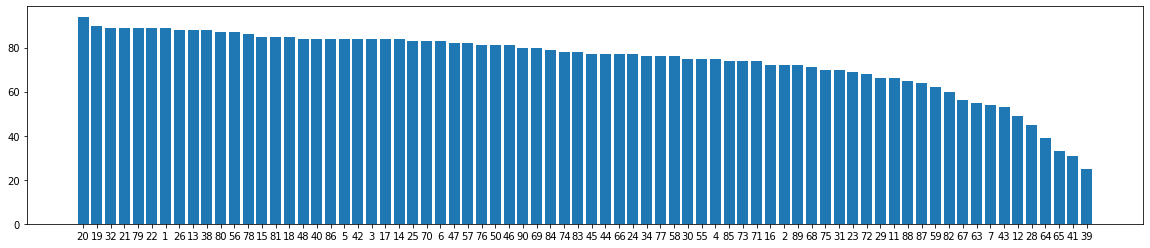

In [55]:
observed_bcrs = pd.read_csv(f"../nextflow/results/{date}/merged-results/observed-seqs.csv")
fig, ax = plt.subplots(figsize=[20, 4])
vc = observed_bcrs.HK_key_gc.value_counts().drop(0)
ax.bar([str(gc) for gc in vc.index], height=vc.values)

In [56]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

In [57]:
τ = 1
τ0 = 0.1

In [58]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def tree_nt_seq_to_dms_aa_seq(sequence):

    igh_aa = aa(sequence[:igk_idx], igh_frame)
    igk_aa = aa(sequence[igk_idx:], igk_frame)

    aa_dms = pos_df.amino_acid.copy()
    aa_dms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_dms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    
    return "".join(aa_dms)

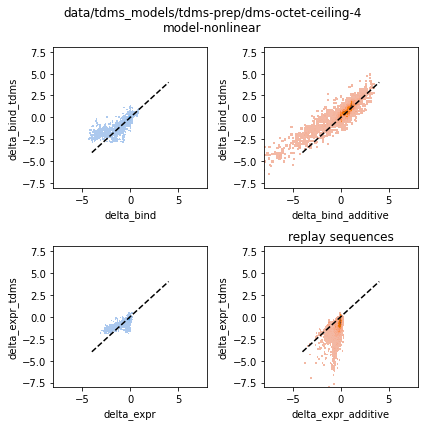

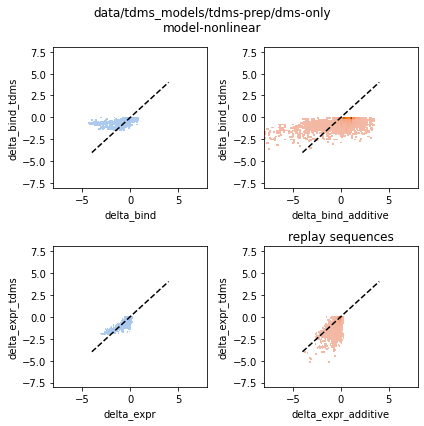

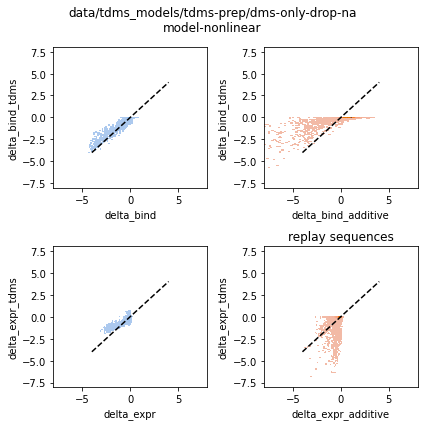

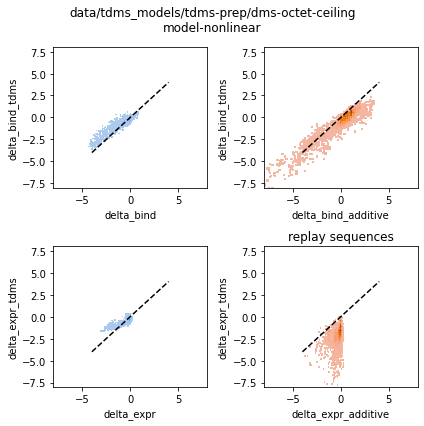

In [60]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    tdms_model = torch.load(f"{dsdir[0]}/{model_prefix}.model", map_location=torch.device('cpu'))
#     print(dsdir[0])
    
#     model_prefix = f"output/tdms/{ds}-bias-{bias}-linear"
#     tdms_model = torch.load(f"{model_prefix}.model", map_location=torch.device('cpu'))
#     print(model_prefix)

    for gc, tree in trees.items():

        # rename tuple names with last element of tuple (possible danger)
        if isinstance(tree.tree.name, tuple):
            tree.tree.name = tree.tree.name[-1]

        tree.local_branching(tau=τ, tau0=τ0)

        naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
        naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

        for node in tree.tree.traverse():

            igh_aa = aa(node.sequence[:igk_idx], igh_frame)
            igk_aa = aa(node.sequence[igk_idx:], igk_frame)
            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
            all_mutations = igh_mutations + igk_mutations
            if any("*" in x for x in all_mutations):
                delta_bind = np.nan
                delta_expr = np.nan
                delta_psr = np.nan
            else:
                delta_bind = dms_df.delta_bind[all_mutations].sum()
                delta_expr = dms_df.delta_expr[all_mutations].sum()
                delta_psr = dms_df.delta_psr[all_mutations].sum()

            node.add_feature("delta_bind_additive", delta_bind)
            node.add_feature("delta_expr_additive", delta_expr)
            node.add_feature("delta_psr_additive", delta_psr)

            tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach()# - tdms_prediction_naive

            node.add_feature("delta_bind_tdms", tdms_prediction[0].item())
            node.add_feature("delta_expr_tdms", tdms_prediction[1].item())


#         print(min((node.delta_bind_additive, (gc, node.name)) for gc, tree in trees.items() for node in tree.tree.traverse() if node.abundance))
    rows = []
    for gc, tree in trees.items():
        for node in tree.tree.traverse():
            if node.abundance:
                rows.append([node.delta_bind_tdms, node.delta_bind_additive, node.delta_expr_tdms, node.delta_expr_additive])

    tdmsVSadditive_df = pd.DataFrame(rows, columns=["delta_bind_tdms", "delta_bind_additive", "delta_expr_tdms", "delta_expr_additive"])
    def single_mut_seq(row):
        aa_seq = pos_df.amino_acid.copy()
        assert aa_seq[row.position] == row.wildtype
        aa_seq[row.position] = row.mutant
        aa_seq = "".join(aa_seq)
        tdms_prediction = tdms_model(tdms_model.seq_to_binary(aa_seq)).detach()
        return tdms_prediction

    dms_df[["delta_bind_tdms", "delta_expr_tdms"]] = dms_df.apply(single_mut_seq, axis=1, result_type="expand")
#         plt.figure(figsize=(6, 6))

    fig, ax = plt.subplots(2, 2, figsize=(6, 6))

    sns.histplot(
        data=dms_df, 
        x="delta_bind", 
        y="delta_bind_tdms", 
        color="C0",
        ax=ax[0, 0]
    )
    ax[0, 0].plot((-4, 4), (-4, 4), 'k--',)
    ax[0, 0].set_xlim(-8, 8)
    ax[0, 0].set_ylim(-8, 8)
    plt.title("single mutant effects")

    sns.histplot(
        data=tdmsVSadditive_df, 
        x="delta_bind_additive", 
        y="delta_bind_tdms", 
        color="C1",
        ax=ax[0, 1]
    )
    ax[0, 1].plot((-4, 4), (-4, 4), 'k--',)
    ax[0, 1].set_xlim(-8, 8)
    ax[0, 1].set_ylim(-8, 8)
    plt.title("replay sequences")

    sns.histplot(
        data=dms_df, 
        x="delta_expr", 
        y="delta_expr_tdms", 
        color="C0",
        ax=ax[1,0]
    )
    ax[1,0].plot((-4, 4), (-4, 4), 'k--',)
    ax[1,0].set_xlim(-8, 8)
    ax[1,0].set_ylim(-8, 8)

    sns.histplot(
        data=tdmsVSadditive_df, 
        x="delta_expr_additive", 
        y="delta_expr_tdms", 
        color="C1",
        ax=ax[1,1]
    )
    ax[1,1].plot((-4, 4), (-4, 4), 'k--',)
    ax[1,1].set_xlim(-8, 8)
    ax[1,1].set_ylim(-8, 8)

    fig.suptitle(f"{dsdir[0]}\n{model_prefix}")
    plt.tight_layout()
    plt.show()
    saveto = f"{dsdir[0]}/{model_prefix}-all-gctree-scatter.png"
    fig.savefig(saveto)
